In [1]:
import os
import time
import warnings
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from deepMNN import correct_scanpy
from metrics import compute_entropy, silhouette_coeff_ASW

import anndata as ad
import scanpy as sc
from src.models import scETM
from src.trainers import UnsupervisedTrainer,prepare_for_transfer
from src import  evaluate
sc.set_figure_params(dpi=120, dpi_save=250, fontsize=10, figsize=(10, 10), facecolor="white")

warnings.filterwarnings("ignore")

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100)
sc.settings.set_figure_params(dpi_save=300)
sc.logging.print_version_and_date()

os.environ["CUDA_VISIBLE_DEVICES"]="2"

Running Scanpy 1.8.2, on 2021-12-18 21:21.


In [2]:
mp_csvs = ['GSM2230761_mouse1_umifm_counts.csv', 'GSM2230762_mouse2_umifm_counts.csv']
mp_adatas = []
for fpath in mp_csvs:
    df = pd.read_csv(fpath, index_col=0)
    adata = ad.AnnData(X=df.iloc[:, 2:], obs=df.iloc[:, :2])
    mp_adatas.append(adata)
adata= ad.concat(mp_adatas, label="batch_indices")

In [3]:
#adata = sc.read_h5ad('data/dataset5.h5ad')

#adata = adata[(adata.obs.batch != '0') | (adata.obs.celltype != 'B cell')]
#adata = adata[(adata.obs.batch != '1') | (adata.obs.celltype != 'NK cell')]
#adata = adata[(adata.obs.batch != '1') | (adata.obs.celltype != 'Monocyte_CD14')]
#adata = adata[(adata.obs.batch != '0') | (adata.obs.celltype != 'CD8 T cell')]


sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:,adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

normalizing by total count per cell
    finished (0:00:10): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:09)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:11)


In [4]:
batch_names = adata.obs['batch_indices'].value_counts().index.values
adatas = [adata[adata.obs['batch_indices'] == batch_names[i]] for i in range(0, len(batch_names))]

# Before batch correction

In [5]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
asw_raw = silhouette_coeff_ASW(adata,batch_key='batch_indices',celltype_key='assigned_cluster')
entropy_raw=compute_entropy(adata,batch_key='batch_indices',celltype_key='assigned_cluster')

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:20)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:24)
Calculating entropy ...
use exist neighbors
Entropy calculated!


... storing 'barcode' as categorical
... storing 'assigned_cluster' as categorical


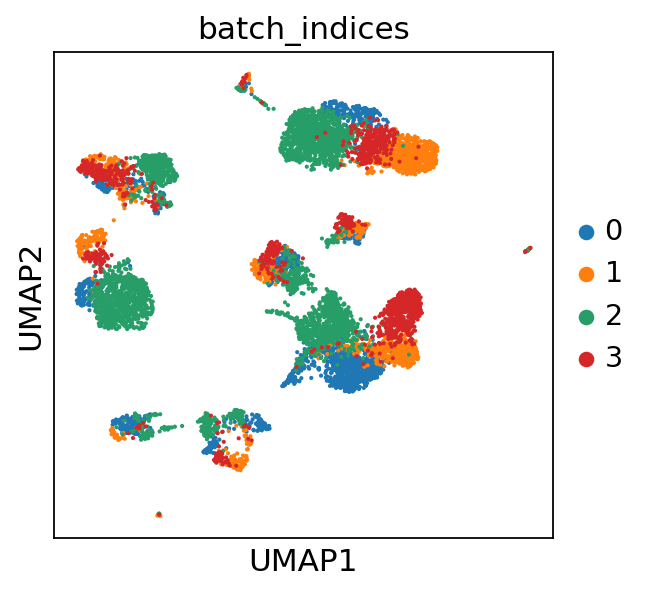

In [6]:
sc.pl.umap(adata,color='batch_indices',save='_figure4_raw_batch.pdf')

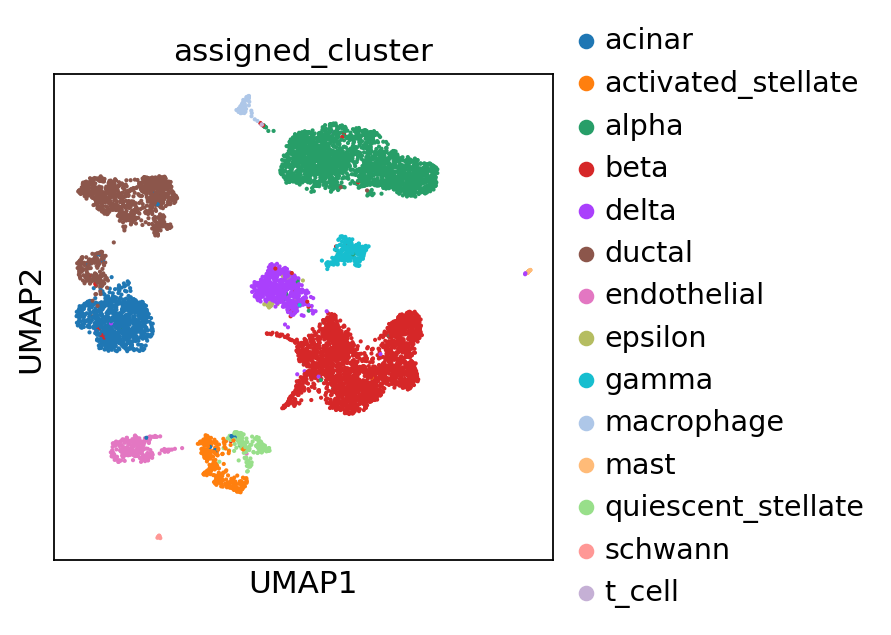

In [7]:
sc.pl.umap(adata,color='assigned_cluster',save='_figure4_raw_celltype.pdf')

# Batch correction using deepMNN

In [8]:
time_s = time.time()
corrected = correct_scanpy(adatas)
print('time used:', time.time()-time_s)

adata_result = corrected[0].concatenate(corrected[1:], join='inner', batch_key = 'batch_indices')
sc.tl.pca(adata_result, svd_solver='arpack')
sc.pp.neighbors(adata_result)
sc.tl.umap(adata_result)

asw_deepMNN = silhouette_coeff_ASW(adata_result,batch_key='batch_indices',celltype_key='assigned_cluster')
entropy_deepMNN=compute_entropy(adata_result,celltype_key='assigned_cluster',batch_key='batch_indices')


[[0.         0.74806402 0.33178654 0.36607828]
 [0.         0.         0.45431079 0.38142748]
 [0.         0.         0.         0.63573086]
 [0.         0.         0.         0.        ]]
Epoch 0, loss: 771.036, counter: 0
Learning rate = 0.1000000
Epoch 1, loss: 191.222, counter: 0
Learning rate = 0.1000000
Epoch 2, loss: 109.503, counter: 0
Learning rate = 0.1000000
Epoch 3, loss: 98.102, counter: 0
Learning rate = 0.1000000
Epoch 4, loss: 90.370, counter: 0
Learning rate = 0.1000000
Epoch 5, loss: 82.332, counter: 0
Learning rate = 0.1000000
Epoch 6, loss: 81.026, counter: 0
Learning rate = 0.1000000
Epoch 7, loss: 79.349, counter: 0
Learning rate = 0.1000000
Epoch 8, loss: 78.637, counter: 0
Learning rate = 0.1000000
Epoch 9, loss: 74.200, counter: 0
Learning rate = 0.1000000
Epoch 10, loss: 71.805, counter: 0
Learning rate = 0.1000000
Epoch 11, loss: 73.033, counter: 1
Learning rate = 0.1000000
Epoch 12, loss: 74.993, counter: 2
Learning rate = 0.1000000
Epoch 13, loss: 71.233, c

... storing 'barcode' as categorical
... storing 'assigned_cluster' as categorical


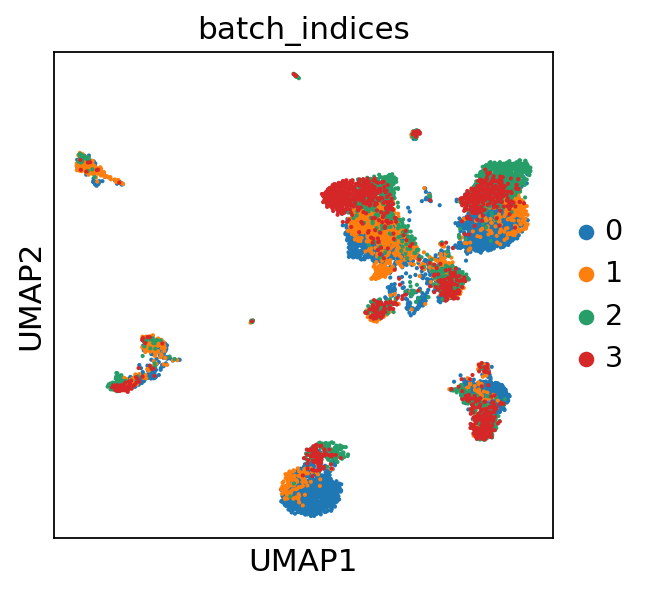

In [9]:
#adata_result.obs['batch'] = ['10X 3\'' if i == '0' else '10X 5\'' for i in adata_result.obs['batch']]
sc.pl.umap(adata_result,color='batch_indices',save='_figure4_deepMNN_batch.pdf')

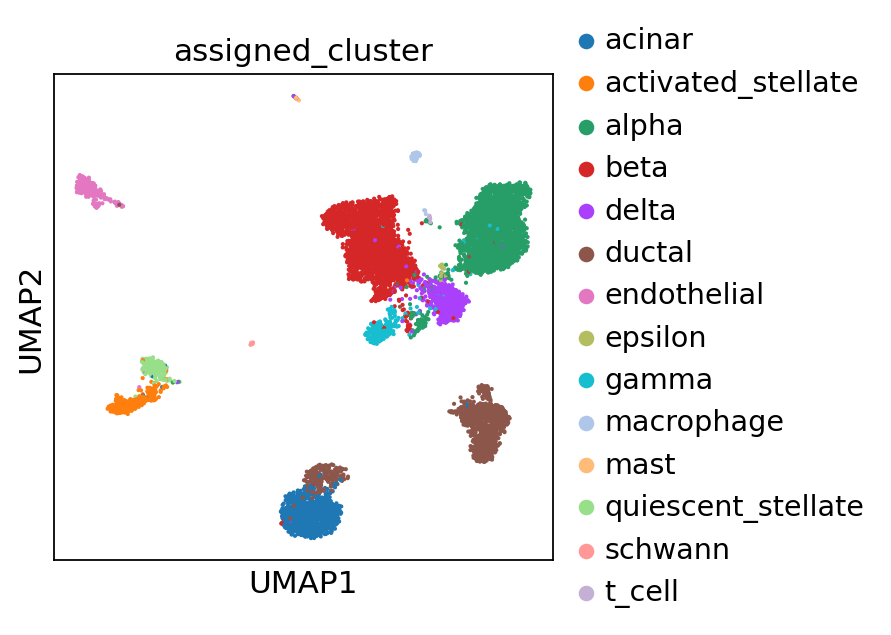

In [10]:
sc.pl.umap(adata_result,color='assigned_cluster',save='_figure4_deepMNN_celltype.pdf')

In [11]:
ann_model = scETM(adata_result.n_vars,1,device="cuda:2")
trainer = UnsupervisedTrainer(ann_model, adata_result, test_ratio=0.1)
trainer.train(n_epochs = 12000, eval_every = 3000, eval_kwargs = dict(cell_type_col = 'assigned_cluster'), save_model_ckpt = False)

[2021-12-18 21:28:24,222] INFO - scETM.logging_utils: scETM.__init__(2000, 1, device = cuda:2)
caonima

n_batches == 1, disabling batch bias
[2021-12-18 21:28:31,901] INFO - scETM.logging_utils: UnsupervisedTrainer.__init__(scETM(
  (q_delta): Sequential(
    (0): Linear(in_features=2000, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
  )
  (mu_q_delta): Linear(in_features=128, out_features=50, bias=True)
  (logsigma_q_delta): Linear(in_features=128, out_features=50, bias=True)
  (rho_trainable_emb): PartlyTrainableParameter2D(height=400, fixed=0, trainable=2000)
), AnnData object with n_obs × n_vars = 8569 × 2000
    obs: 'barcode', 'assigned_cluster', 'batch_indices', 'n_counts'
    uns: 'pca', 'neighbors', 'umap', 'batch_indices_colors', 'assigned_cluster_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', test_ratio 

[2021-12-18 21:28:34,266] INFO - scETM.logging_utils: evaluate(adata = AnnData object with n_obs × n_vars = 8569 × 2000
    obs: 'barcode', 'assigned_cluster', 'batch_indices', 'n_counts'
    uns: 'pca', 'neighbors', 'umap', 'batch_indices_colors', 'assigned_cluster_colors'
    obsm: 'X_pca', 'X_umap', 'delta'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', embedding_key = delta, batch_col = batch_indices, plot_fname = scETM_delta_epoch0, plot_dir = None, writer = None, cell_type_col = assigned_cluster)
[2021-12-18 21:28:36,855] INFO - scETM.eval_utils: Performing leiden clustering


running Leiden clustering
    finished: found 2 clusters and added
    'leiden_0.01', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:28:37,447] INFO - scETM.eval_utils: Resolution:  0.01	ARI:  0.0161	NMI:  0.0513	bARI:  0.0023	# labels: 2


running Leiden clustering
    finished: found 3 clusters and added
    'leiden_0.02', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:28:38,071] INFO - scETM.eval_utils: Resolution:  0.02	ARI:  0.3184	NMI:  0.4678	bARI: -0.0076	# labels: 3


running Leiden clustering
    finished: found 3 clusters and added
    'leiden_0.04', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:28:38,977] INFO - scETM.eval_utils: Resolution:  0.04	ARI:  0.3191	NMI:  0.4689	bARI: -0.0076	# labels: 3


running Leiden clustering
    finished: found 4 clusters and added
    'leiden_0.08', the cluster labels (adata.obs, categorical) (0:00:01)


[2021-12-18 21:28:40,073] INFO - scETM.eval_utils: Resolution:  0.08	ARI:  0.3540	NMI:  0.5388	bARI: -0.0088	# labels: 4


running Leiden clustering
    finished: found 4 clusters and added
    'leiden_0.16', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:28:40,849] INFO - scETM.eval_utils: Resolution:  0.16	ARI:  0.3547	NMI:  0.5397	bARI: -0.0086	# labels: 4


running Leiden clustering
    finished: found 5 clusters and added
    'leiden_0.32', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:28:41,707] INFO - scETM.eval_utils: Resolution:  0.32	ARI:  0.3596	NMI:  0.5507	bARI: -0.0080	# labels: 5


running Leiden clustering
    finished: found 8 clusters and added
    'leiden_0.64', the cluster labels (adata.obs, categorical) (0:00:01)


[2021-12-18 21:28:42,957] INFO - scETM.eval_utils: Resolution:  0.64	ARI:  0.3951	NMI:  0.5473	bARI:  0.0158	# labels: 8
[2021-12-18 21:28:45,962] INFO - scETM.eval_utils: delta_ASW: -0.0930
[2021-12-18 21:28:45,981] INFO - scETM.eval_utils: SW: batch_indices              0         1         2         3
assigned_cluster                                          
acinar             -0.264122 -0.280236 -0.180527 -0.270889
activated_stellate -0.710765 -0.631576 -0.547882 -0.512496
alpha              -0.028243 -0.019003  0.006338  0.000455
beta                0.067642  0.067665  0.067663  0.063613
delta              -0.035384 -0.036488 -0.031285 -0.029888
ductal             -0.158199 -0.174126 -0.168777 -0.164216
endothelial        -0.682204 -0.683121 -0.497291 -0.568025
epsilon            -0.066680 -0.185009 -0.068477 -0.137488
gamma              -0.081047 -0.044664 -0.056404 -0.037946
macrophage         -0.069963 -0.112696 -0.071486 -0.030713
mast               -0.451063 -0.424046 -0.3216

[2021-12-18 21:31:29,289] INFO - scETM.logging_utils: evaluate(adata = AnnData object with n_obs × n_vars = 8569 × 2000
    obs: 'barcode', 'assigned_cluster', 'batch_indices', 'n_counts', 'leiden_0.01', 'leiden_0.02', 'leiden_0.04', 'leiden_0.08', 'leiden_0.16', 'leiden_0.32', 'leiden_0.64', 'silhouette_width'
    uns: 'pca', 'neighbors', 'umap', 'batch_indices_colors', 'assigned_cluster_colors', 'leiden'
    obsm: 'X_pca', 'X_umap', 'delta', 'knn_indices'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', embedding_key = delta, batch_col = batch_indices, plot_fname = scETM_delta_epoch3000, plot_dir = None, writer = None, cell_type_col = assigned_cluster)
[2021-12-18 21:31:31,359] INFO - scETM.eval_utils: Performing leiden clustering


running Leiden clustering
    finished: found 2 clusters and added
    'leiden_0.01', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:31:31,903] INFO - scETM.eval_utils: Resolution:  0.01	ARI:  0.3140	NMI:  0.4618	bARI: -0.0060	# labels: 2


running Leiden clustering
    finished: found 3 clusters and added
    'leiden_0.02', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:31:32,419] INFO - scETM.eval_utils: Resolution:  0.02	ARI:  0.3656	NMI:  0.5549	bARI: -0.0087	# labels: 3


running Leiden clustering
    finished: found 4 clusters and added
    'leiden_0.04', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:31:32,978] INFO - scETM.eval_utils: Resolution:  0.04	ARI:  0.3748	NMI:  0.5729	bARI: -0.0205	# labels: 4


running Leiden clustering
    finished: found 7 clusters and added
    'leiden_0.08', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:31:33,545] INFO - scETM.eval_utils: Resolution:  0.08	ARI:  0.3241	NMI:  0.5198	bARI:  0.0141	# labels: 7


running Leiden clustering
    finished: found 12 clusters and added
    'leiden_0.16', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:31:34,197] INFO - scETM.eval_utils: Resolution:  0.16	ARI:  0.2434	NMI:  0.4730	bARI:  0.0069	# labels: 12


running Leiden clustering
    finished: found 15 clusters and added
    'leiden_0.32', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:31:34,858] INFO - scETM.eval_utils: Resolution:  0.32	ARI:  0.2262	NMI:  0.4725	bARI:  0.0046	# labels: 15


running Leiden clustering
    finished: found 21 clusters and added
    'leiden_0.64', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:31:35,559] INFO - scETM.eval_utils: Resolution:  0.64	ARI:  0.1580	NMI:  0.4383	bARI:  0.0095	# labels: 21
[2021-12-18 21:31:37,601] INFO - scETM.eval_utils: delta_ASW: -0.0984
[2021-12-18 21:31:37,621] INFO - scETM.eval_utils: SW: batch_indices              0         1         2         3
assigned_cluster                                          
acinar              0.121383  0.111923  0.082265  0.106895
activated_stellate -0.759325 -0.690252 -0.593382 -0.549282
alpha              -0.138144 -0.085278 -0.042979 -0.032916
beta               -0.131032 -0.092422 -0.073263 -0.072811
delta               0.129287  0.102370  0.051366  0.071743
ductal             -0.027502 -0.013728 -0.063579 -0.017428
endothelial        -0.680516 -0.657013 -0.484973 -0.607985
epsilon            -0.153210 -0.350511 -0.152165 -0.481929
gamma              -0.216765 -0.069346 -0.084233 -0.066519
macrophage          0.070874  0.005982  0.083864  0.216173
mast               -0.824282 -0.822536 -0.720

[2021-12-18 21:34:07,152] INFO - scETM.logging_utils: evaluate(adata = AnnData object with n_obs × n_vars = 8569 × 2000
    obs: 'barcode', 'assigned_cluster', 'batch_indices', 'n_counts', 'leiden_0.01', 'leiden_0.02', 'leiden_0.04', 'leiden_0.08', 'leiden_0.16', 'leiden_0.32', 'leiden_0.64', 'silhouette_width'
    uns: 'pca', 'neighbors', 'umap', 'batch_indices_colors', 'assigned_cluster_colors', 'leiden'
    obsm: 'X_pca', 'X_umap', 'delta', 'knn_indices'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', embedding_key = delta, batch_col = batch_indices, plot_fname = scETM_delta_epoch6000, plot_dir = None, writer = None, cell_type_col = assigned_cluster)
[2021-12-18 21:34:08,972] INFO - scETM.eval_utils: Performing leiden clustering


running Leiden clustering
    finished: found 2 clusters and added
    'leiden_0.01', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:34:09,436] INFO - scETM.eval_utils: Resolution:  0.01	ARI:  0.3140	NMI:  0.4621	bARI: -0.0059	# labels: 2


running Leiden clustering
    finished: found 3 clusters and added
    'leiden_0.02', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:34:09,987] INFO - scETM.eval_utils: Resolution:  0.02	ARI:  0.3645	NMI:  0.5505	bARI: -0.0090	# labels: 3


running Leiden clustering
    finished: found 6 clusters and added
    'leiden_0.04', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:34:10,439] INFO - scETM.eval_utils: Resolution:  0.04	ARI:  0.3342	NMI:  0.4947	bARI: -0.0110	# labels: 6


running Leiden clustering
    finished: found 8 clusters and added
    'leiden_0.08', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:34:10,956] INFO - scETM.eval_utils: Resolution:  0.08	ARI:  0.2562	NMI:  0.4698	bARI:  0.0180	# labels: 8


running Leiden clustering
    finished: found 12 clusters and added
    'leiden_0.16', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:34:11,573] INFO - scETM.eval_utils: Resolution:  0.16	ARI:  0.2309	NMI:  0.4648	bARI:  0.0106	# labels: 12


running Leiden clustering
    finished: found 17 clusters and added
    'leiden_0.32', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:34:12,181] INFO - scETM.eval_utils: Resolution:  0.32	ARI:  0.1820	NMI:  0.4433	bARI:  0.0078	# labels: 17


running Leiden clustering
    finished: found 22 clusters and added
    'leiden_0.64', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:34:12,766] INFO - scETM.eval_utils: Resolution:  0.64	ARI:  0.1529	NMI:  0.4287	bARI:  0.0048	# labels: 22
[2021-12-18 21:34:14,701] INFO - scETM.eval_utils: delta_ASW: -0.1148
[2021-12-18 21:34:14,717] INFO - scETM.eval_utils: SW: batch_indices              0         1         2         3
assigned_cluster                                          
acinar              0.118933  0.104697  0.109396  0.145475
activated_stellate -0.726313 -0.656240 -0.574886 -0.528129
alpha              -0.155594 -0.084322 -0.042409 -0.036709
beta               -0.158336 -0.113703 -0.091251 -0.093591
delta               0.155769  0.137629  0.087750  0.104481
ductal             -0.122532 -0.113763 -0.137978 -0.097946
endothelial        -0.687971 -0.653975 -0.488282 -0.656275
epsilon            -0.169682 -0.355219 -0.246254 -0.401557
gamma              -0.278715 -0.096316 -0.112549 -0.091907
macrophage          0.193719  0.154495  0.162001  0.273419
mast               -0.815106 -0.806421 -0.705

[2021-12-18 21:36:18,403] INFO - scETM.logging_utils: evaluate(adata = AnnData object with n_obs × n_vars = 8569 × 2000
    obs: 'barcode', 'assigned_cluster', 'batch_indices', 'n_counts', 'leiden_0.01', 'leiden_0.02', 'leiden_0.04', 'leiden_0.08', 'leiden_0.16', 'leiden_0.32', 'leiden_0.64', 'silhouette_width'
    uns: 'pca', 'neighbors', 'umap', 'batch_indices_colors', 'assigned_cluster_colors', 'leiden'
    obsm: 'X_pca', 'X_umap', 'delta', 'knn_indices'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', embedding_key = delta, batch_col = batch_indices, plot_fname = scETM_delta_epoch9000, plot_dir = None, writer = None, cell_type_col = assigned_cluster)
[2021-12-18 21:36:20,147] INFO - scETM.eval_utils: Performing leiden clustering


running Leiden clustering
    finished: found 3 clusters and added
    'leiden_0.01', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:36:20,925] INFO - scETM.eval_utils: Resolution:  0.01	ARI:  0.3515	NMI:  0.5445	bARI: -0.0101	# labels: 3


running Leiden clustering
    finished: found 4 clusters and added
    'leiden_0.02', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:36:21,497] INFO - scETM.eval_utils: Resolution:  0.02	ARI:  0.3624	NMI:  0.5380	bARI: -0.0099	# labels: 4


running Leiden clustering
    finished: found 7 clusters and added
    'leiden_0.04', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:36:21,981] INFO - scETM.eval_utils: Resolution:  0.04	ARI:  0.2688	NMI:  0.4495	bARI:  0.0052	# labels: 7


running Leiden clustering
    finished: found 9 clusters and added
    'leiden_0.08', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:36:22,573] INFO - scETM.eval_utils: Resolution:  0.08	ARI:  0.2712	NMI:  0.4757	bARI:  0.0084	# labels: 9


running Leiden clustering
    finished: found 13 clusters and added
    'leiden_0.16', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:36:23,338] INFO - scETM.eval_utils: Resolution:  0.16	ARI:  0.2184	NMI:  0.4518	bARI:  0.0026	# labels: 13


running Leiden clustering
    finished: found 17 clusters and added
    'leiden_0.32', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:36:23,907] INFO - scETM.eval_utils: Resolution:  0.32	ARI:  0.1665	NMI:  0.4246	bARI:  0.0096	# labels: 17


running Leiden clustering
    finished: found 25 clusters and added
    'leiden_0.64', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:36:24,470] INFO - scETM.eval_utils: Resolution:  0.64	ARI:  0.1340	NMI:  0.4177	bARI:  0.0054	# labels: 25
[2021-12-18 21:36:26,644] INFO - scETM.eval_utils: delta_ASW: -0.1168
[2021-12-18 21:36:26,658] INFO - scETM.eval_utils: SW: batch_indices              0         1         2         3
assigned_cluster                                          
acinar              0.088762  0.074466  0.085128  0.128351
activated_stellate -0.714568 -0.643654 -0.569635 -0.514880
alpha              -0.146649 -0.066797 -0.019580 -0.012939
beta               -0.165471 -0.120539 -0.096379 -0.098690
delta               0.162589  0.151448  0.093912  0.114220
ductal             -0.130429 -0.123742 -0.140732 -0.099197
endothelial        -0.680789 -0.656679 -0.483310 -0.624359
epsilon            -0.178618 -0.342774 -0.266881 -0.322942
gamma              -0.284716 -0.100348 -0.121373 -0.101251
macrophage          0.005263 -0.062810  0.019307  0.103573
mast               -0.789815 -0.778484 -0.656

[2021-12-18 21:38:39,249] INFO - scETM.logging_utils: evaluate(adata = AnnData object with n_obs × n_vars = 8569 × 2000
    obs: 'barcode', 'assigned_cluster', 'batch_indices', 'n_counts', 'leiden_0.01', 'leiden_0.02', 'leiden_0.04', 'leiden_0.08', 'leiden_0.16', 'leiden_0.32', 'leiden_0.64', 'silhouette_width'
    uns: 'pca', 'neighbors', 'umap', 'batch_indices_colors', 'assigned_cluster_colors', 'leiden'
    obsm: 'X_pca', 'X_umap', 'delta', 'knn_indices'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', embedding_key = delta, batch_col = batch_indices, plot_fname = scETM_delta_epoch12000, plot_dir = None, writer = None, cell_type_col = assigned_cluster)
[2021-12-18 21:38:41,188] INFO - scETM.eval_utils: Performing leiden clustering


running Leiden clustering
    finished: found 3 clusters and added
    'leiden_0.01', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:38:41,730] INFO - scETM.eval_utils: Resolution:  0.01	ARI:  0.3270	NMI:  0.4811	bARI: -0.0062	# labels: 3


running Leiden clustering
    finished: found 4 clusters and added
    'leiden_0.02', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:38:42,228] INFO - scETM.eval_utils: Resolution:  0.02	ARI:  0.3651	NMI:  0.5545	bARI: -0.0068	# labels: 4


running Leiden clustering
    finished: found 6 clusters and added
    'leiden_0.04', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:38:42,891] INFO - scETM.eval_utils: Resolution:  0.04	ARI:  0.3253	NMI:  0.4885	bARI:  0.0002	# labels: 6


running Leiden clustering
    finished: found 8 clusters and added
    'leiden_0.08', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:38:43,497] INFO - scETM.eval_utils: Resolution:  0.08	ARI:  0.2670	NMI:  0.4539	bARI:  0.0039	# labels: 8


running Leiden clustering
    finished: found 13 clusters and added
    'leiden_0.16', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:38:44,171] INFO - scETM.eval_utils: Resolution:  0.16	ARI:  0.2088	NMI:  0.4554	bARI:  0.0089	# labels: 13


running Leiden clustering
    finished: found 18 clusters and added
    'leiden_0.32', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:38:45,135] INFO - scETM.eval_utils: Resolution:  0.32	ARI:  0.1639	NMI:  0.4265	bARI:  0.0078	# labels: 18


running Leiden clustering
    finished: found 24 clusters and added
    'leiden_0.64', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:38:46,176] INFO - scETM.eval_utils: Resolution:  0.64	ARI:  0.1360	NMI:  0.4182	bARI:  0.0054	# labels: 24
[2021-12-18 21:38:48,133] INFO - scETM.eval_utils: delta_ASW: -0.1147
[2021-12-18 21:38:48,149] INFO - scETM.eval_utils: SW: batch_indices              0         1         2         3
assigned_cluster                                          
acinar              0.090859  0.078568  0.087691  0.136535
activated_stellate -0.708471 -0.636109 -0.565272 -0.509420
alpha              -0.132761 -0.051977 -0.005153  0.003485
beta               -0.163779 -0.121559 -0.102436 -0.104863
delta               0.145772  0.135739  0.077650  0.099508
ductal             -0.138216 -0.130985 -0.145658 -0.104995
endothelial        -0.676722 -0.655748 -0.480898 -0.616633
epsilon            -0.171285 -0.316594 -0.281127 -0.244054
gamma              -0.279285 -0.097508 -0.121327 -0.101193
macrophage         -0.061691 -0.125114 -0.036651  0.062619
mast               -0.761449 -0.741315 -0.611

In [12]:
ann_model.get_cell_embeddings_and_nll(adata_result)

0.13448572264542336

[2021-12-18 21:38:54,041] INFO - scETM.logging_utils: evaluate(AnnData object with n_obs × n_vars = 8569 × 2000
    obs: 'barcode', 'assigned_cluster', 'batch_indices', 'n_counts', 'leiden_0.01', 'leiden_0.02', 'leiden_0.04', 'leiden_0.08', 'leiden_0.16', 'leiden_0.32', 'leiden_0.64', 'silhouette_width'
    uns: 'pca', 'neighbors', 'umap', 'batch_indices_colors', 'assigned_cluster_colors', 'leiden'
    obsm: 'X_pca', 'X_umap', 'delta', 'knn_indices', 'theta'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', resolutions = [0.1, 0.13, 0.19, 0.22, 0.25, 0.28], return_fig = True, cell_type_col = assigned_cluster, batch_col = batch_indices)
[2021-12-18 21:38:56,090] INFO - scETM.eval_utils: Performing leiden clustering


running Leiden clustering
    finished: found 8 clusters and added
    'leiden_0.1', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:38:56,568] INFO - scETM.eval_utils: Resolution:   0.1	ARI:  0.2420	NMI:  0.4412	bARI:  0.0123	# labels: 8


running Leiden clustering
    finished: found 10 clusters and added
    'leiden_0.13', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:38:57,128] INFO - scETM.eval_utils: Resolution:  0.13	ARI:  0.2427	NMI:  0.4524	bARI:  0.0023	# labels: 10


running Leiden clustering
    finished: found 13 clusters and added
    'leiden_0.19', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:38:57,993] INFO - scETM.eval_utils: Resolution:  0.19	ARI:  0.2084	NMI:  0.4417	bARI:  0.0064	# labels: 13


running Leiden clustering
    finished: found 15 clusters and added
    'leiden_0.22', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:38:58,576] INFO - scETM.eval_utils: Resolution:  0.22	ARI:  0.1909	NMI:  0.4317	bARI:  0.0061	# labels: 15


running Leiden clustering
    finished: found 13 clusters and added
    'leiden_0.25', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:38:59,131] INFO - scETM.eval_utils: Resolution:  0.25	ARI:  0.2012	NMI:  0.4338	bARI:  0.0065	# labels: 13


running Leiden clustering
    finished: found 15 clusters and added
    'leiden_0.28', the cluster labels (adata.obs, categorical) (0:00:00)


[2021-12-18 21:38:59,828] INFO - scETM.eval_utils: Resolution:  0.28	ARI:  0.1912	NMI:  0.4334	bARI:  0.0069	# labels: 15
[2021-12-18 21:39:01,847] INFO - scETM.eval_utils: delta_ASW: -0.1147
[2021-12-18 21:39:01,862] INFO - scETM.eval_utils: SW: batch_indices              0         1         2         3
assigned_cluster                                          
acinar              0.090859  0.078568  0.087691  0.136535
activated_stellate -0.708471 -0.636109 -0.565272 -0.509420
alpha              -0.132761 -0.051977 -0.005153  0.003485
beta               -0.163779 -0.121559 -0.102436 -0.104863
delta               0.145772  0.135739  0.077650  0.099508
ductal             -0.138216 -0.130985 -0.145658 -0.104995
endothelial        -0.676722 -0.655748 -0.480898 -0.616633
epsilon            -0.171285 -0.316594 -0.281127 -0.244054
gamma              -0.279285 -0.097508 -0.121327 -0.101193
macrophage         -0.061691 -0.125114 -0.036651  0.062619
mast               -0.761449 -0.741315 -0.611

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:27)


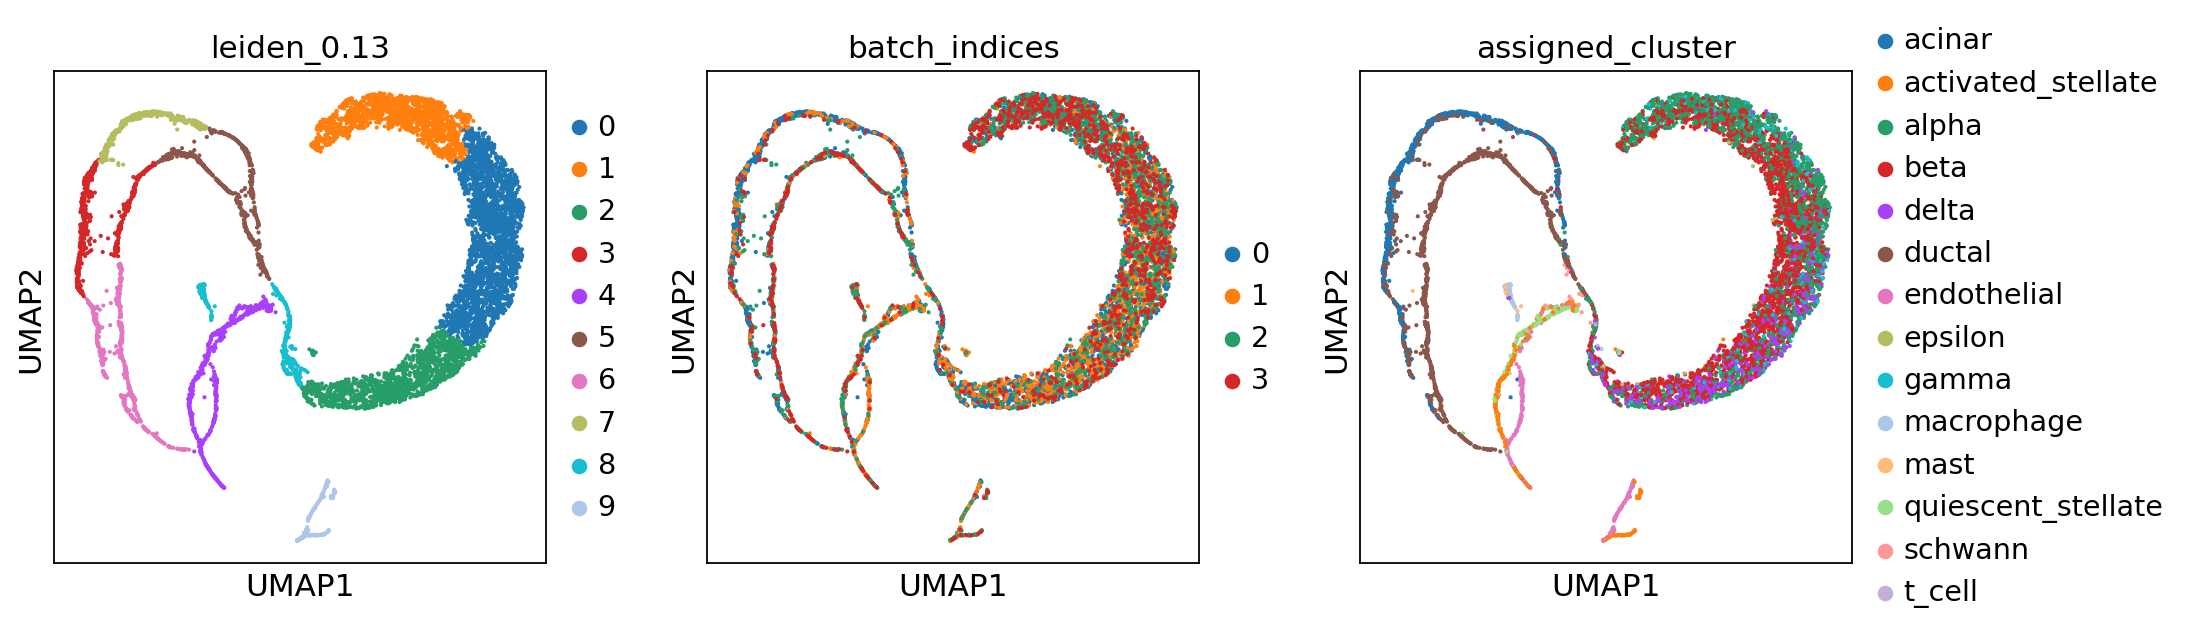

In [13]:
result = evaluate(adata_result, resolutions = [0.1, 0.13, 0.19, 0.22, 0.25, 0.28], return_fig=True, cell_type_col="assigned_cluster", batch_col="batch_indices")